In [1]:
import os
import sys

sys.path.append('../')

import h5py
import matplotlib.pyplot as plt
import numba
import numpy as np
import torch
from numpy.fft import fft, fft2, fftshift, ifft, ifft2, ifftshift
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from kwave.ktransducer import *
from kwave.utils import *
from models.ADMM import ADMM_Batched
from models.FISTA import FISTA_Batched
from models.HQS import HQS_Batched
from models.WienerNet import Wiener_Batched, WienerNet
from utils.simulations import PSF, center, wavefront_real
from utils.utils_torch import get_fourier_coord

os.environ["CUDA_VISIBLE_DEVICES"] = '2'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load in Brain Data

(512, 2000)


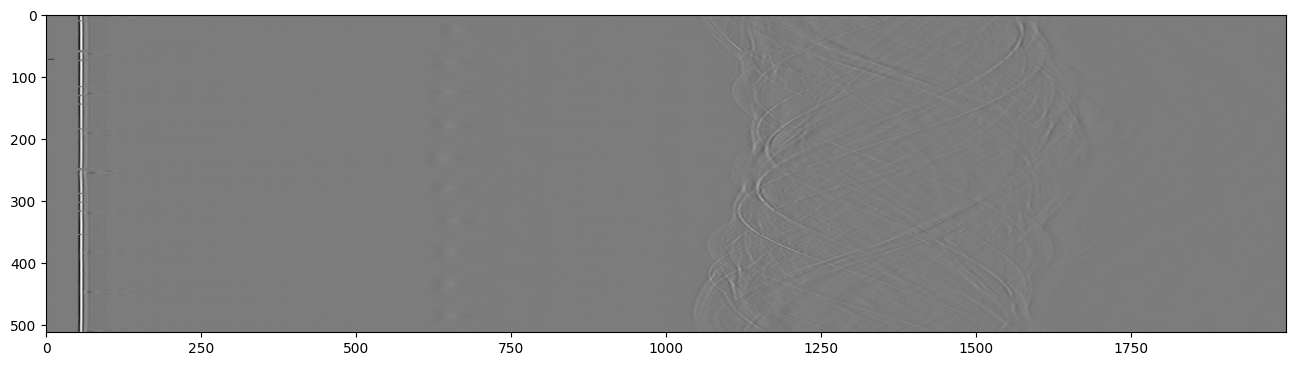

In [2]:
data = h5py.File('data/ANIMAL_LAYER.mat')
sinogram = np.array(data['Sinogram'])
print(sinogram.shape)
plt.subplots(figsize=(16,5))
plt.imshow(sinogram[:,], cmap='gray')
plt.show()

(1, 2000)


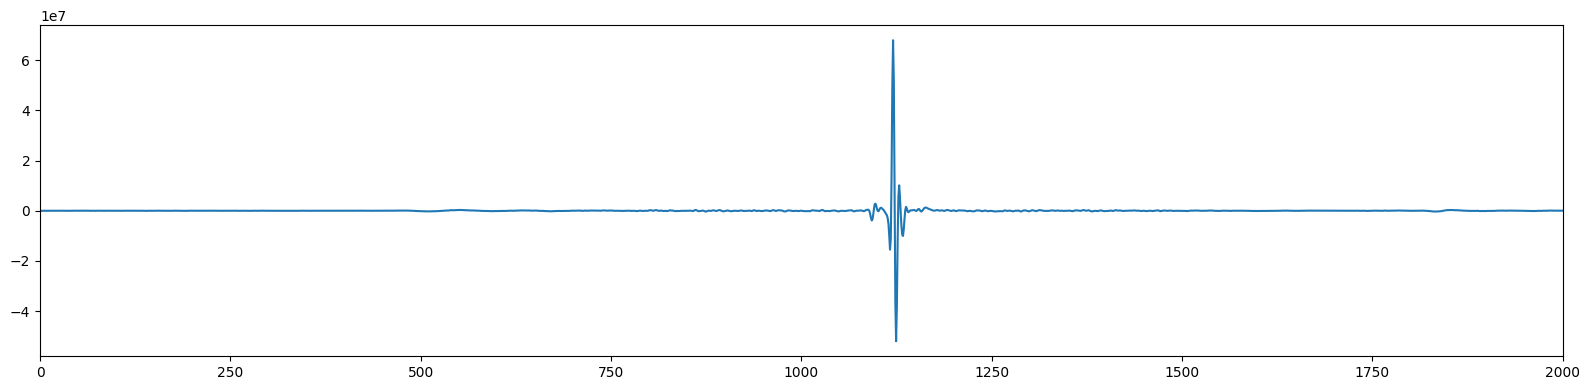

In [3]:
EIR_data = h5py.File('data/EIR_TUNGSTEN.mat')
EIR = np.array(EIR_data['EIR_AVE_20180516_LEFT'])
print(EIR.shape)

time = np.linspace(0, 2000, 2000)
plt.figure(figsize=(16,4))
plt.plot(time, np.squeeze(EIR[:2000]))
plt.xlim(0, 2000)
plt.tight_layout()

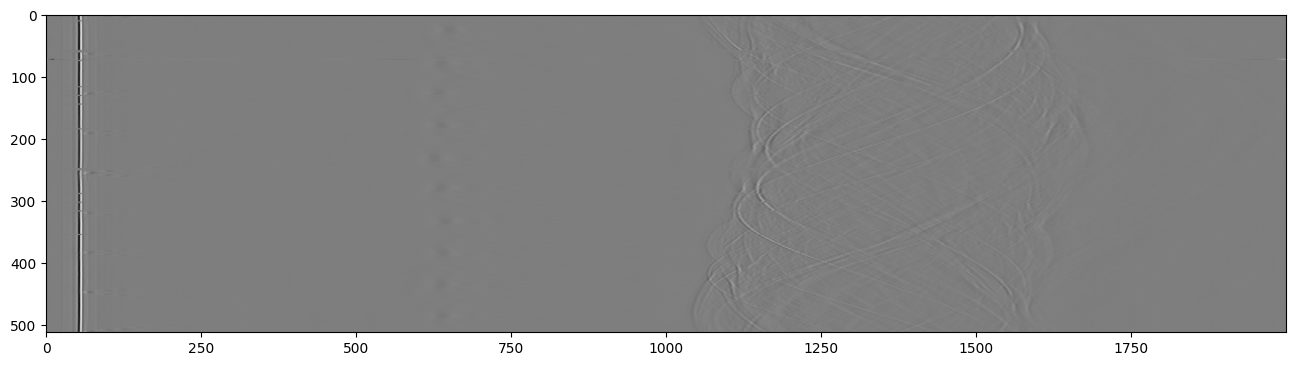

In [4]:
def deconvolve_sinogram(sinogram, EIR, t0):
    """Correct EIR phase of the sinogram.

    Args:
        sinogram (`numpy.array`): _description_
        EIR (`numpy.array`): EIR of the transducer.
        t0 (`int`): Time index of the EIR peak.

    Returns:
        `numpy.array`: The corrected sinogrm.
    """
    delta = np.zeros_like(EIR)
    delta[0, t0] = 1
    delta_ft = fft(delta, axis=1)
    EIR_ft = fft(EIR, axis=1)
    Sinogram_ft = fft(sinogram, axis=1)
    Sinogram_ft *= np.exp(1j * (np.angle(delta_ft) - np.angle(EIR_ft)))
    
    return np.real((ifft(Sinogram_ft, axis=1)))

t0 = np.argmax(EIR)    
sinogram_deconv = deconvolve_sinogram(sinogram, EIR, t0)
plt.subplots(figsize=(16,5))
plt.imshow(sinogram_deconv, cmap='gray')
plt.show()

In [5]:
Nx, Ny = 750, 750
R_ring = 0.05   # Radius of the ring array [m].
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])

In [6]:
@numba.jit(nopython=True) 
def delay_and_sum(R_ring, T_sample, V_sound, Sinogram, ImageX, ImageY, d_delay=0):
    """Generate a 2D Delay And Sum recontructed PACT image of ring transducer array. This function is accelerated by `numba.jit` on a GPU.

    Args:
        R_ring (`float`): The R_ring [m] of the ring transducer array.
        T_sample (`float`): Sample time interval [s] of the signals.
        V_sound (`float`): The sound speed [m/s] used for Delay And Sum recontruction.
        Sinogram (`numpy.ndarray`): A 2D array and each column of it is the signal recievde by one transducer. The nummber of transducers should be the number of columns. The transducers should be evenly distributed on a circle in counterclockwise arrangement and the first column correspond to the transducer in the dirrection `2pi/N` in the first quartile. The first sample should be at time 0 when the photoacoustic effect happens.
        ImageX (`numpy.ndarray`): The vector [m] defining the x coordinates of the grid points on which the recontruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        ImageY (`numpy.ndarray`): The vector [m] defining the y coordinates of the grid points on which the recontruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        d_delay (`float`): The delay distance [m] of the signals used in DAS. The default value is 0.

    Returns:
        `numpy.ndarray`: A 2D array of size `(len(ImageY), len(ImageX))`. `Image[t, s]` is the recontructed photoacoustic amplitude at the grid point `(ImageX[s], ImageY[t])`.
    """

    N_transducer = Sinogram.shape[0]
    Image = np.zeros((len(ImageX), len(ImageY)))
    delta_angle = 2*np.pi / N_transducer
    angle_transducer = delta_angle * (np.arange(N_transducer,) + 1)
    
    R_ring = R_ring #- 40e-6 - 120e-6 * np.cos(2 * angle_transducer) + 5e-5 # Ring Array Correction 

    x_transducer = R_ring * np.sin(angle_transducer - np.pi)
    y_transducer = R_ring * np.cos(angle_transducer - np.pi)
    
    related_data = np.zeros((N_transducer,))
    
    for s in range(len(ImageX)):
        for t in range(len(ImageY)):
            distance_to_transducer = np.sqrt((x_transducer - ImageX[s])**2 + (y_transducer - ImageY[t])**2) - d_delay
            for k in range(N_transducer):
                id = floor(distance_to_transducer[k]/(V_sound * T_sample))
                if id > Sinogram.shape[1] or id < 0:
                    related_data[k] = 0
                else:
                    related_data[k] = Sinogram[k, id]
            Image[t, s] = related_data.mean()
    return Image

### Conventional DAS

In [7]:
baseline = delay_and_sum(R_ring=0.05,
                         T_sample=1/(40e6),
                         V_sound=1515.0,
                         Sinogram=sinogram_deconv[:,46:],
                         ImageX=kgrid.x_vec[:],
                         ImageY=kgrid.y_vec[:],
                         d_delay=0)
img_size = 560
x_c, y_c = center(baseline)
baseline = baseline[-22+x_c-img_size//2:-22+x_c+img_size//2, y_c-img_size//2:y_c+img_size//2]

Text(0.5, 1.0, 'Histogram')

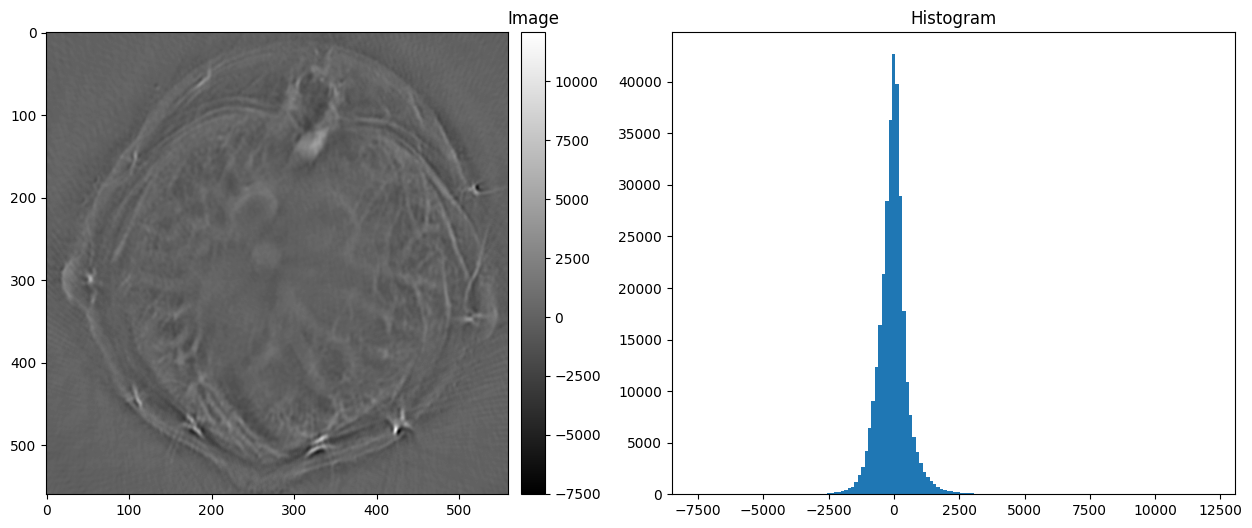

In [8]:
fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(1,2,1)
plt.imshow(baseline, cmap='gray')
cax = fig.add_axes([ax1.get_position().x1+0.008, ax1.get_position().y0, 0.015, ax1.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.title('Image', fontsize=12)

ax2 = plt.subplot(1,2,2)
plt.hist(baseline.ravel(), bins=150)
plt.title('Histogram', fontsize=12)

In [9]:
def get_water_SoS(t):
    """Calculate the speed of sound of water at temperature `t` in Celsius."""
    a = [1.402385e3, 5.038813, -5.799136e-2, 3.287156e-4, -1.398845e-6, 2.787860e-9]
    SoS = 0
    for i in range(len(a)):
        SoS += a[i] * t**i
    return SoS

R = 9.6e-3 # Radius to center [m].
l = 3.2e-3 # Patch size [m].
T = 31.0 # Temperature of water [C].
v0 = get_water_SoS(T) # SoS in water [m/s].
v1 = 1545. # Average SoS in tissue [m/s].
print(v0, v1)

1511.439223811262 1545.0


In [10]:
def get_delays(R, v0, v1, n_delays, mode='linear'):
    if mode == 'linear':
        return np.linspace(0, (1-v0/v1) * R, n_delays)
    elif mode == 'quadric':
        return (1-v0/v1) * R * np.sqrt(np.linspace(0,1,n_delays))
    else:
        raise NotImplementedError()
    
n_delays = 16
delays = get_delays(R, v0, v1, n_delays, 'linear')
print(delays)

recons = []
for d_delay in delays:
    recon = delay_and_sum(R_ring=0.05,
                          T_sample=1/(40e6), 
                          V_sound=v0,
                          Sinogram=sinogram_deconv[:,46:],
                          ImageX=kgrid.x_vec[:],
                          ImageY=kgrid.y_vec[:],
                          d_delay=d_delay)
    recons.append(recon)

[0.00000000e+00 1.39021986e-05 2.78043971e-05 4.17065957e-05
 5.56087942e-05 6.95109928e-05 8.34131913e-05 9.73153899e-05
 1.11217588e-04 1.25119787e-04 1.39021986e-04 1.52924184e-04
 1.66826383e-04 1.80728581e-04 1.94630780e-04 2.08532978e-04]


In [11]:
recons = np.array(recons)
x_c, y_c = center(recons[0])
recons = recons[:,-30+x_c-img_size//2:-30+x_c+img_size//2, y_c-img_size//2+11:y_c+img_size//2+11]

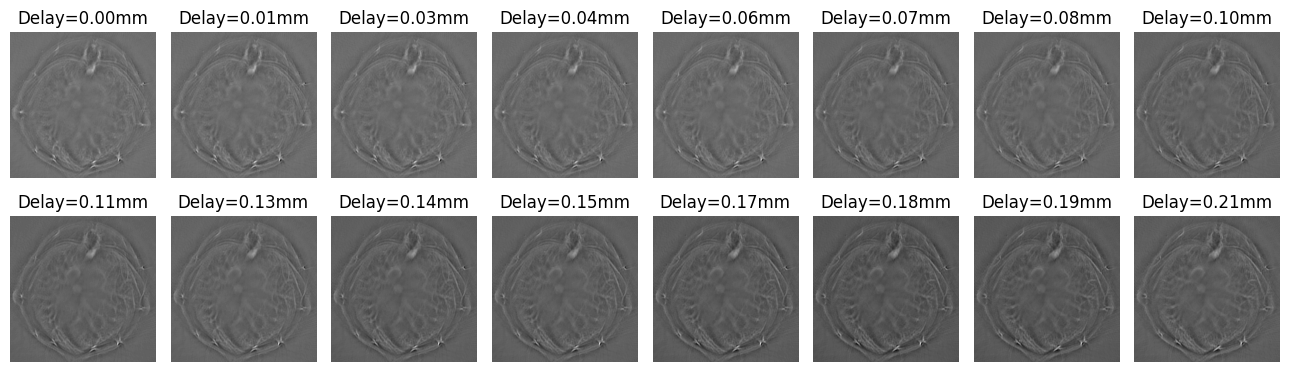

In [12]:
plt.figure(figsize=(13, 4))
for idx, d_delay in enumerate(delays):
    ax1 = plt.subplot(2,8,idx+1)
    plt.imshow(recons[idx,:,:], cmap='gray')
    plt.title('Delay={:.2f}mm'.format(d_delay*1e3), fontsize=12)
    plt.axis('off')
plt.tight_layout()

In [13]:
l = 3.2e-3        
psfs, obss = [], []
recons = np.array(recons)
for i in range(25):
    for j in range(25):
        obs = torch.Tensor(recons[:,20*i:20*i+80, 20*j:20*j+80])
        obss.append(obs)
        
        x, y = (j-12)*l / 4, (12-i)*l / 4
        r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
        w_real = wavefront_real(R, r, phi, v0, v1)
        k2D, theta2D = get_fourier_coord(n_points=80, l=l, device='cpu')
        psf = []
        for id, delay in enumerate(delays):
            psf.append(PSF(theta2D, k2D, w_real, delay))
        psfs.append(torch.stack(psf, dim=0))

In [14]:
wiener = Wiener_Batched(lam=0.1)
admm = ADMM_Batched(n_iters=16, lam=0.1, rho=0.03)
hqs = HQS_Batched(n_iters=16, lam=0.1, rho=0.03)
fista = FISTA_Batched(n_iters=20, lam=0.10)

### Small Patch

In [15]:
i, j = 23, 14
x, y = (j-12)*l / 4, (12-i)*l / 4
r = np.sqrt(x**2 + y**2)
C0 = (1-v0/v1) * R * (1 - (r**2)/(4*R**2))
print('r={:.2f}mm   C0={:.2f}mm'.format(r*1e3, C0*1e3))

r=8.94mm   C0=0.16mm


In [16]:
obs, psf = torch.Tensor(obss[i*25+j]), psfs[i*25+j]
obs, psf = obs.unsqueeze(0).to(device), psf.unsqueeze(0).to(device)
mean = obs.abs().mean()
with torch.no_grad():
    rec_wiener = wiener(obs/mean, psf) * mean
    rec_admm = admm(obs/mean, psf) * mean
    rec_hqs = hqs(obs/mean, psf) * mean
    rec_fista = fista(obs/mean, psf) * mean
obs = obs.squeeze(0).detach().cpu().numpy()
psf = psf.squeeze(0).detach().cpu().numpy()
rec_wiener = rec_wiener.squeeze(0).squeeze(0).detach().cpu().numpy()
rec_wiener /= np.abs(rec_wiener).mean()
rec_admm = rec_admm.squeeze(0).squeeze(0).detach().cpu().numpy()
rec_admm /= np.abs(rec_admm).mean()
rec_hqs = rec_hqs.squeeze(0).squeeze(0).detach().cpu().numpy()
rec_hqs /= np.abs(rec_hqs).mean()
rec_fista = rec_fista.squeeze(0).squeeze(0).detach().cpu().numpy()
rec_fista /= np.abs(rec_fista).mean()

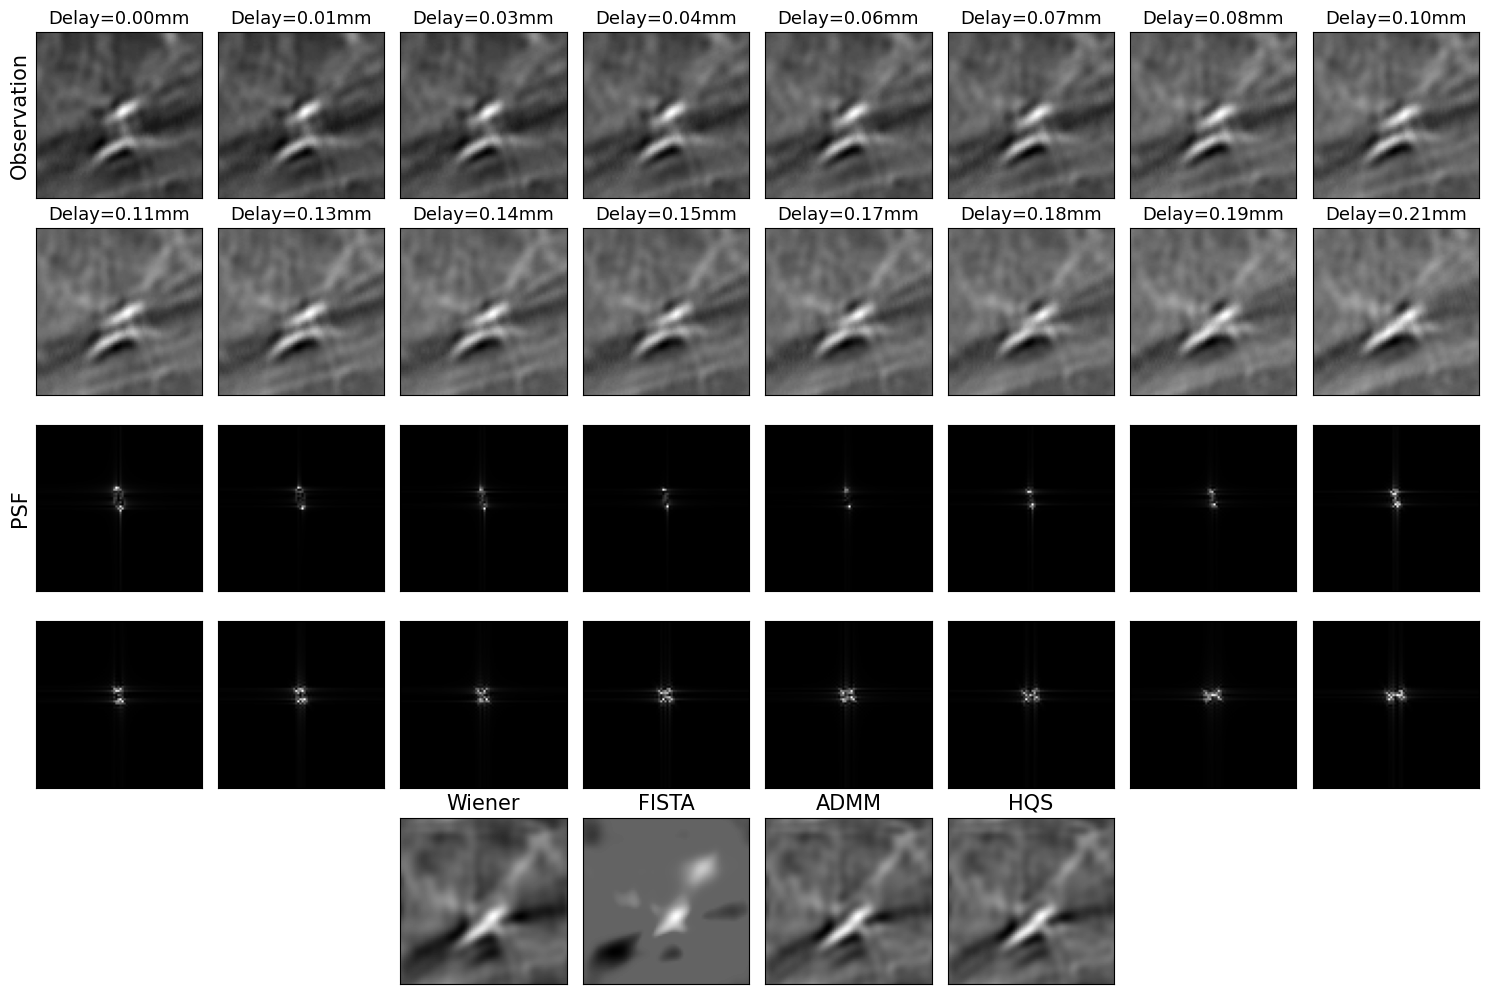

In [17]:
plt.figure(figsize=(15,10))
for i in range(n_delays):
    plt.subplot(5,8,i+1)
    plt.imshow(obs[i], cmap='gray')
    plt.title('Delay={:.2f}mm'.format(delays[i]*1e3), fontsize=13)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Observation', fontsize=15)
    
    plt.subplot(5,8,i+17)
    plt.imshow(psf[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('PSF', fontsize=15)
    
plt.subplot(5,8,3+2*n_delays)
plt.imshow(rec_wiener, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Wiener', fontsize=15)

plt.subplot(5,8,4+2*n_delays)
plt.imshow(rec_fista, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('FISTA', fontsize=15)

plt.subplot(5,8,5+2*n_delays)
plt.imshow(rec_admm, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('ADMM', fontsize=15)

plt.subplot(5,8,6+2*n_delays)
plt.imshow(rec_hqs, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('HQS', fontsize=15)
    
plt.tight_layout()

In [18]:
def gaussian_kernel(sigma, size):
    function = lambda x,y: np.exp(-((x-(size-1)/2)**2 + (y-(size-1)/2)**2) / (2*(sigma**2)))
    kernel = np.fromfunction(function, (size, size), dtype=float)
    return kernel / np.sum(kernel)

fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = gaussian_kernel(sigma, 80)

In [19]:
def deconv_full_img(model, recons, gaussian_window):
    model.to(device)
    model.eval()

    rec_full = np.zeros_like(recons[0])
    for i in range(25):
        for j in range(25):
            obs, psf = obss[i*25+j], psfs[i*25+j]
            mean = obs.abs().mean()
            obs, psf = obs.unsqueeze(0).to(device), psf.unsqueeze(0).to(device)
            with torch.no_grad():
                rec = model(obs/mean, psf) * mean
            rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
            rec_full[20*i:20*i+80, 20*j:20*j+80] += rec * gaussian_window
    
    return rec_full


rec_full_wiener = deconv_full_img(wiener, recons, gaussian_window)
rec_full_admm = deconv_full_img(admm, recons, gaussian_window)
rec_full_hqs = deconv_full_img(hqs, recons, gaussian_window)
rec_full_fista = deconv_full_img(fista, recons, gaussian_window)

(0.0, 1.0, 0.0, 1.0)

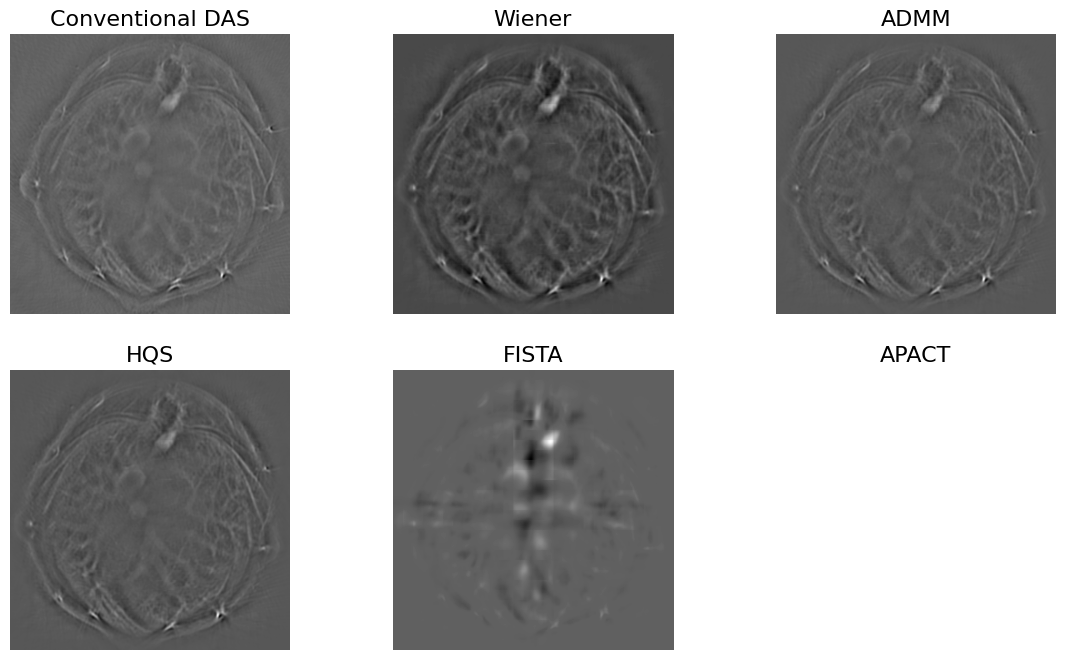

In [20]:
fig = plt.figure(figsize=(14, 8))

ax1 = plt.subplot(2,3,1)
plt.imshow(baseline, cmap='gray')
plt.title('Conventional DAS', fontsize=16)
plt.axis('off')
# cax = fig.add_axes([ax1.get_position().x1+0.01, ax1.get_position().y0, 0.012, ax1.get_position().height])
# cb = plt.colorbar(cax=cax)

ax2 = plt.subplot(2,3,2)
plt.imshow(rec_full_wiener, cmap='gray')
plt.title('Wiener', fontsize=16)
plt.axis('off')
# cax = fig.add_axes([ax2.get_position().x1+0.01, ax2.get_position().y0, 0.012, ax2.get_position().height])
# cb = plt.colorbar(cax=cax)

ax3 = plt.subplot(2,3,3)
plt.imshow(rec_full_admm, cmap='gray')
plt.title('ADMM', fontsize=16)
plt.axis('off')
# cax = fig.add_axes([ax3.get_position().x1+0.01, ax3.get_position().y0, 0.012, ax3.get_position().height])
# cb = plt.colorbar(cax=cax)

ax4 = plt.subplot(2,3,4)
plt.imshow(rec_full_hqs, cmap='gray')
plt.title('HQS', fontsize=16)
plt.axis('off')
# cax = fig.add_axes([ax3.get_position().x1+0.01, ax3.get_position().y0, 0.012, ax3.get_position().height])
# cb = plt.colorbar(cax=cax)

ax5 = plt.subplot(2,3,5)
plt.imshow(rec_full_fista, cmap='gray')
plt.title('FISTA', fontsize=16)
plt.axis('off')
# cax = fig.add_axes([ax3.get_position().x1+0.01, ax3.get_position().y0, 0.012, ax3.get_position().height])
# cb = plt.colorbar(cax=cax)

ax6 = plt.subplot(2,3,6)
# plt.imshow(rec_full_apact, cmap='gray')
plt.title('APACT', fontsize=16)
plt.axis('off')
# cax = fig.add_axes([ax3.get_position().x1+0.01, ax3.get_position().y0, 0.012, ax3.get_position().height])
# cb = plt.colorbar(cax=cax)

In [21]:
assert False

AssertionError: 

### WienerNet

In [ ]:
plt.figure(figsize=(14, 4))
for idx, d_delay in enumerate(delays):
    x, y = 320, 480
    plt.subplot(2,8,idx+1)
    plt.imshow(recons[idx,x:x+80,y:y+80], cmap='gray')
    plt.title('Delay={:.2f}mm'.format(d_delay*1e3), fontsize=12)
    plt.axis('off')
    
    x, y = 280, 260
    plt.subplot(2,8,idx+9)
    plt.imshow(recons[idx,x:x+80,y:y+80], cmap='gray')
    plt.axis('off')
plt.tight_layout()

In [ ]:
ncs = [32, 16, 8]
rec_fulls = []
pretrained_epochs = [29, 25, 50] # MultiScale
loss = 'MultiScale' # 'MSE'
for nc, pretrained_epoch in zip(ncs, pretrained_epochs):
    model = WienerNet(nc=[nc, nc*2, nc*4, nc*8])
    model.to(device)
    pretrained_file = os.path.join('../saved_models_Mice_new1/', f'WienerNet_{nc}channels_{loss}_{pretrained_epoch}epochs.pth')
    model.load_state_dict(torch.load(pretrained_file, map_location=torch.device(device)))
    print(f'Successfully loaded in {pretrained_file}.')
    model.eval()
    
    rec_full, weights = np.zeros_like(recons[3]), np.zeros_like(recons[3])
    for i in range(25):
        for j in range(25):
            obs, psf = obss[i*25+j], psfs[i*25+j]
            mean = obs.abs().mean()
            obs, psf = obs.unsqueeze(0).to(device), psf.to(device)
            with torch.no_grad():
                rec = model(obs/mean, psf) * mean
            rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
            rec_full[20*i:20*i+80, 20*j:20*j+80] += rec * gaussian_window

    rec_fulls.append(rec_full/np.abs(rec_full).mean())

In [ ]:
fig = plt.figure(figsize=(13, 12))

ax2 = plt.subplot(2,2,1)
plt.imshow(baseline, cmap='gray')
plt.title('DAS', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax2.get_position().x1+0.01, ax2.get_position().y0, 0.012, ax2.get_position().height])
cb = plt.colorbar(cax=cax)

ax4 = plt.subplot(2,2,2)
plt.imshow(rec_fulls[0], cmap='gray')
plt.title(f'WienerNet ({ncs[0]} channels)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax4.get_position().x1+0.01, ax4.get_position().y0, 0.012, ax4.get_position().height])
cb = plt.colorbar(cax=cax)

ax5 = plt.subplot(2,2,3)
plt.imshow(rec_fulls[1], cmap='gray')
plt.title(f'WienerNet ({ncs[1]} channels)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax5.get_position().x1+0.01, ax5.get_position().y0, 0.012, ax5.get_position().height])
cb = plt.colorbar(cax=cax)

ax6 = plt.subplot(2,2,4)
plt.imshow(rec_fulls[2], cmap='gray')
plt.title(f'WienerNet ({ncs[2]} channels)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax6.get_position().x1+0.01, ax6.get_position().y0, 0.012, ax6.get_position().height])
cb = plt.colorbar(cax=cax)